In [1]:
import pandas as pd
from sklearn.metrics import fbeta_score
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb


In [2]:
def dmc_score_function(label, y_pred):
    loss = 0.0
    for index, item in enumerate(label):
        if label[index] == 0:
            if y_pred[index] == 0:
                loss += 0.0
            else:
                loss -= 25.0
        else:
            if y_pred[index] == 0:
                loss -= 5.0
            else:
                loss += 5.0
    return loss


def calculate_metrics(x, y, model, tp="scikit"):
    scores = {}
    pred = None
    if tp is "scikit":
        scores['acc'] = model.score(x, y)
        pred = model.predict(x)
    elif tp is "keras":
        pred = model.predict_classes(x)
    scores['dmc'] = dmc_score_function(pred, y)
    scores['f2'] = fbeta_score(pred, y, 2, average='binary')
    return scores


In [3]:
df_train = pd.read_csv("../data/train_new.csv", sep="|")
df_val = pd.read_csv("../data/val_new.csv", sep="|")
df_train['totalScannedLineItems'] =  df_train['totalScanTimeInSeconds'] * df_train['scannedLineItemsPerSecond']
df_val['totalScannedLineItems'] =  df_val['totalScanTimeInSeconds'] * df_val['scannedLineItemsPerSecond']
df_train.head()

df_wo_frauds_balanced = df_train[df_train.fraud!=1].sample(n=df_train[df_train.fraud==1].count()[0])
df_50_50 = df_wo_frauds_balanced.append(df_train[df_train.fraud==1],ignore_index=True).sample(frac=1)
df_50_50.count()
#Validation dataset
df_val_y = df_val.fraud
df_val_x = df_val.drop(['fraud'], axis=1)

#Train balanced
df_train_balanced_y = df_50_50.fraud
df_train_balanced_x = df_50_50.drop(['fraud'], axis=1)

#Train unbalanced
df_train_unbalanced_y = df_train.fraud
df_train_unbalanced_x = df_train.drop(['fraud'], axis=1)

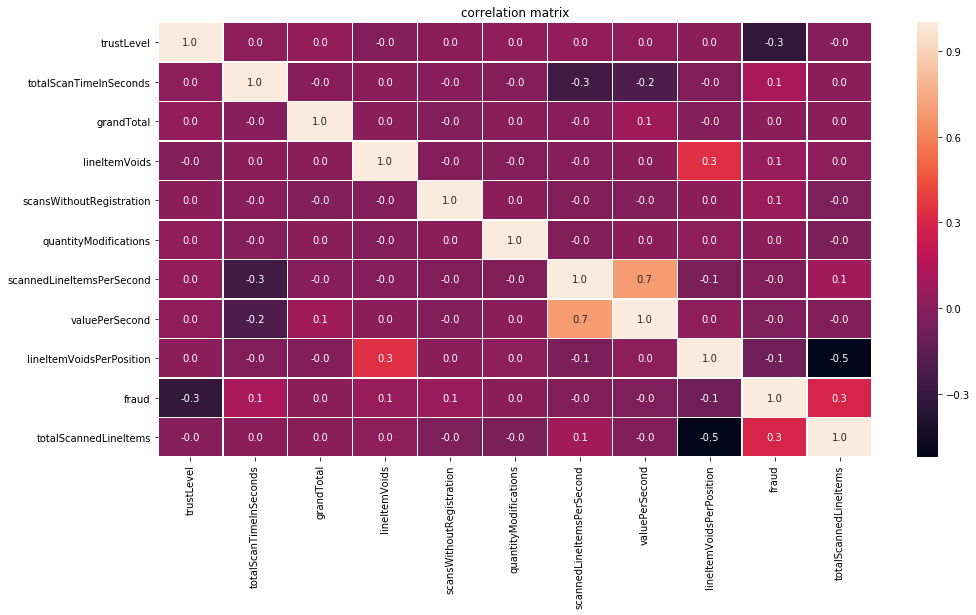

In [4]:
#correlation map
f,ax = plt.subplots(figsize=(16, 8))
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title("correlation matrix")
plt.show()



In [5]:
X = np.array(df_train_unbalanced_x)
y = np.array(df_train_unbalanced_y)
xgb_model = xgb.XGBClassifier(nthread=8, objective="binary:logistic", random_state=42,eval_metric="auc")
xgb_model.fit(df_train_unbalanced_x, df_train_unbalanced_y)
calculate_metrics(df_val_x, df_val_y, xgb_model)

{'acc': 0.9787234042553191, 'dmc': -75.0, 'f2': 0.8585858585858586}

In [6]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))



def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")



In [7]:
xgb_model2 = xgb.XGBClassifier(nthread=8, objective="binary:logistic", random_state=42,eval_metric="auc")
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model2, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model with rank: 1
Mean validation score: 0.989 (std: 0.001)
Parameters: {'n_estimators': 101, 'gamma': 0.13932323211830572, 'colsample_bytree': 0.7154436253749967, 'max_depth': 4, 'learning_rate': 0.30247976578999614, 'subsample': 0.8123738333268545}

Model with rank: 1
Mean validation score: 0.989 (std: 0.002)
Parameters: {'n_estimators': 132, 'gamma': 0.37620156001941135, 'colsample_bytree': 0.999307784777153, 'max_depth': 4, 'learning_rate': 0.2420941383730377, 'subsample': 0.6134129738943117}



[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   18.9s finished


In [12]:
xgb_model = xgb.XGBClassifier(max_depth=5, eval_metric =  'auc', colsample_bytree = 0.796805916483275, learning_rate= 0.30739299906707884,subsample= 0.7011960671956965, gamma= 0.02170039164908638, n_estimators = 136)
xgb_model.fit(df_train_unbalanced_x, df_train_unbalanced_y)
calculate_metrics(df_val_x, df_val_y, xgb_model)


{'acc': 0.9840425531914894, 'dmc': -40.0, 'f2': 0.9090909090909091}

In [14]:
df_val_x['predicted'] = xgb_model.predict(df_val_x)

In [15]:
df_val_x['fraud'] = df_val_y

In [18]:
df_val_x.loc[df_val_x['fraud'] != df_val_x['predicted']]

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScannedLineItems,predicted,fraud
87,1,1486,57.13,4,1,1,0.015478,0.038445,0.173913,23.0,1,0
133,2,1819,60.15,0,7,3,0.016493,0.033068,0.000000,30.0,0,1
176,1,1625,89.93,11,3,0,0.011692,0.055342,0.578947,19.0,0,1
208,2,1641,51.34,10,6,2,0.015235,0.031286,0.400000,25.0,0,1
312,2,1461,39.82,6,9,1,0.017112,0.027255,0.240000,25.0,0,1
353,1,923,72.62,5,9,3,0.022752,0.078678,0.238095,21.0,0,1
